<a href="https://colab.research.google.com/github/RajDalvi08/data-analysis/blob/main/UIDAI_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# CRAZY aesthetics
plt.style.use("dark_background")
sns.set_context("talk")


In [ ]:
files = glob.glob("/content/api_data_aadhar_enrolment_*.csv")
print("Files found:", files)

df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

df.head()



In [ ]:
# Date handling
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Numeric safety
age_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
df[age_cols] = df[age_cols].fillna(0)

# Drop unusable rows
df.dropna(subset=['state', 'district'], inplace=True)

df.info()


NameError: name 'pd' is not defined

In [ ]:
df['total_enrolment'] = df[age_cols].sum(axis=1)

df['adult_ratio'] = df['age_18_greater'] / df['total_enrolment']
df['child_ratio'] = (df['age_0_5'] + df['age_5_17']) / df['total_enrolment']

df.replace([np.inf, -np.inf], 0, inplace=True)

df.head()



,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrolment,adult_ratio,child_ratio
0,2025-12-31,Karnataka,Bidar,585330,2,3,0,5,0.0,1.0
1,2025-12-31,Karnataka,Bidar,585402,6,0,0,6,0.0,1.0
2,2025-12-31,Karnataka,Bidar,585413,1,0,0,1,0.0,1.0
3,2025-12-31,Karnataka,Bidar,585418,1,2,0,3,0.0,1.0
4,2025-12-31,Karnataka,Bidar,585421,4,3,0,7,0.0,1.0


/tmp/ipython-input-1480186962.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


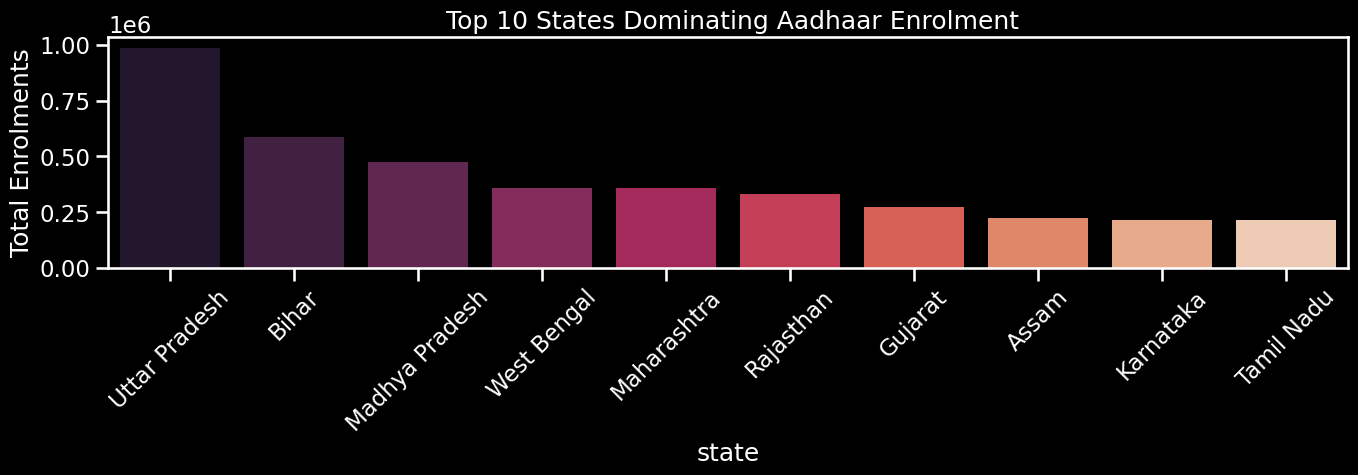

In [ ]:
top_states = (
    df.groupby('state')['total_enrolment']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(16,3))
sns.barplot(
    x=top_states.index,
    y=top_states.values,
    palette="rocket"
)
plt.title(" Top 10 States Dominating Aadhaar Enrolment", fontsize=18)
plt.xticks(rotation=45)
plt.ylabel("Total Enrolments")
plt.show()



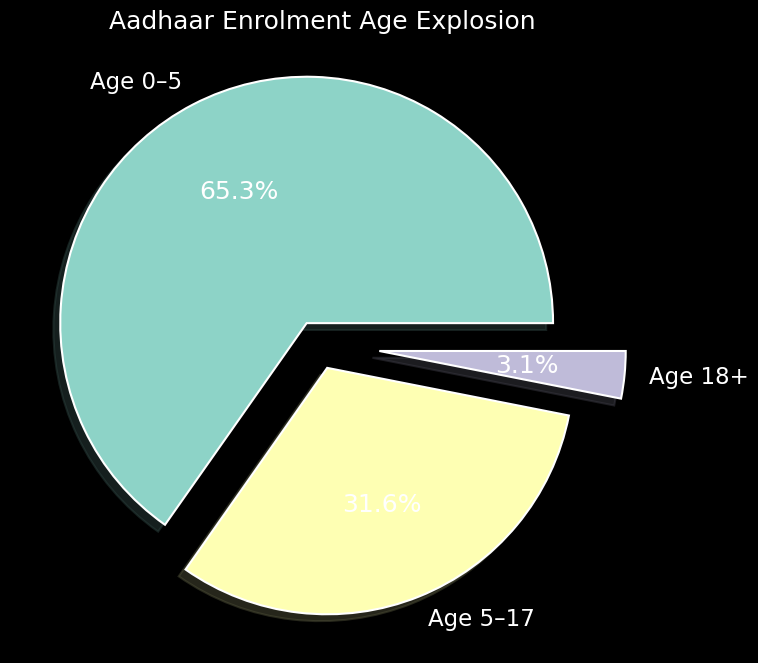

In [ ]:
age_totals = df[age_cols].sum()

plt.figure(figsize=(8,8))
plt.pie(
    age_totals,
    labels=['Age 0–5','Age 5–17','Age 18+'],
    autopct='%1.1f%%',
    explode=[0.1,0.1,0.25],
    shadow=True
)
plt.title(" Aadhaar Enrolment Age Explosion")
plt.show()



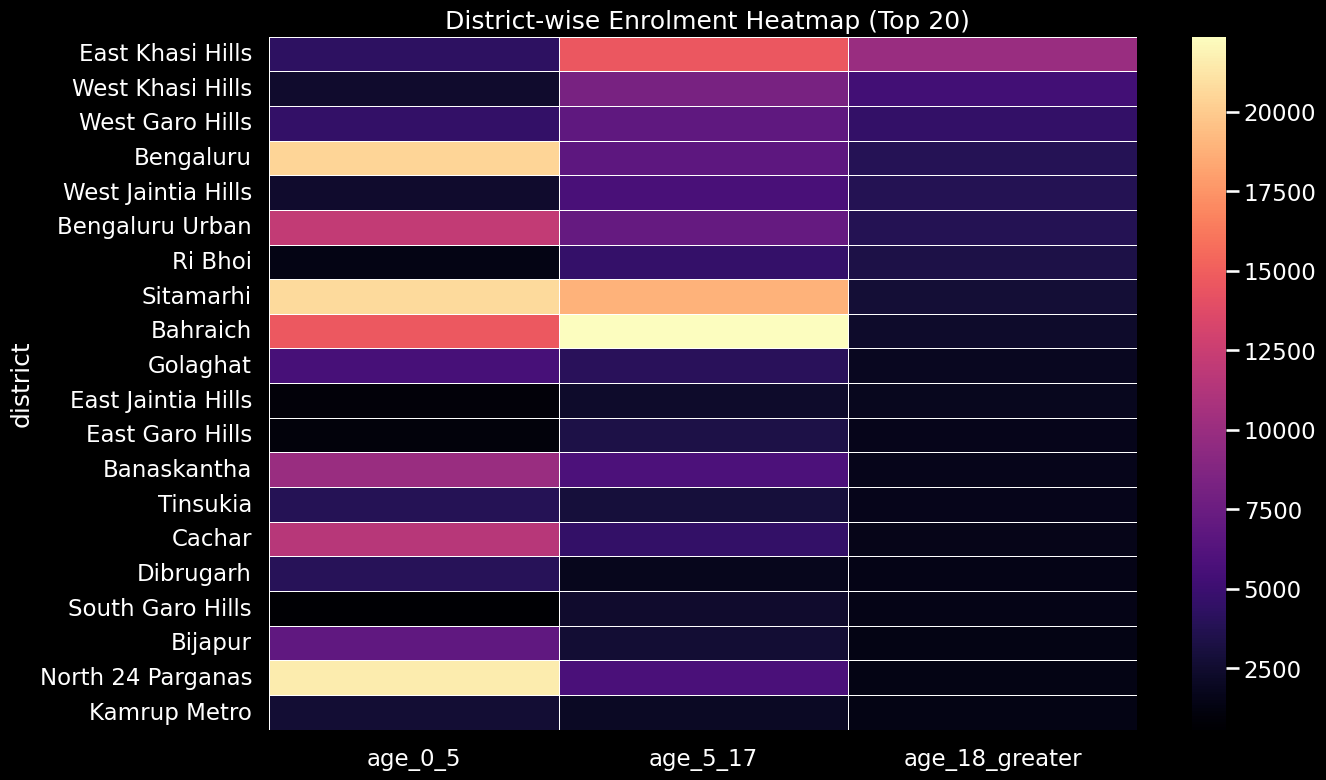

In [ ]:
heat_df = (
    df.groupby('district')[age_cols]
    .sum()
    .sort_values(by='age_18_greater', ascending=False)
    .head(20)
)

plt.figure(figsize=(14,9))
sns.heatmap(
    heat_df,
    cmap="magma",
    linewidths=0.6,
    annot=False
)
plt.title(" District-wise Enrolment Heatmap (Top 20)")
plt.show()



/tmp/ipython-input-2404985958.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['total_enrolment']


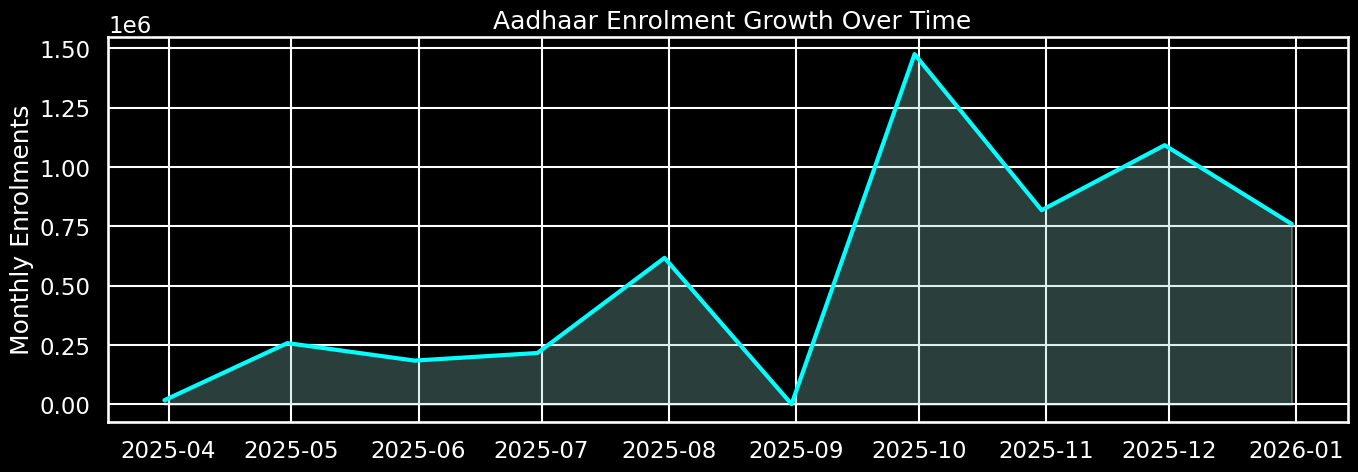

In [ ]:
time_df = (
    df.set_index('date')
      .resample('M')['total_enrolment']
      .sum()
)

plt.figure(figsize=(16,5))
plt.plot(time_df, linewidth=3, color='cyan')
plt.fill_between(time_df.index, time_df.values, alpha=0.3)
plt.title(" Aadhaar Enrolment Growth Over Time")
plt.ylabel("Monthly Enrolments")
plt.show()


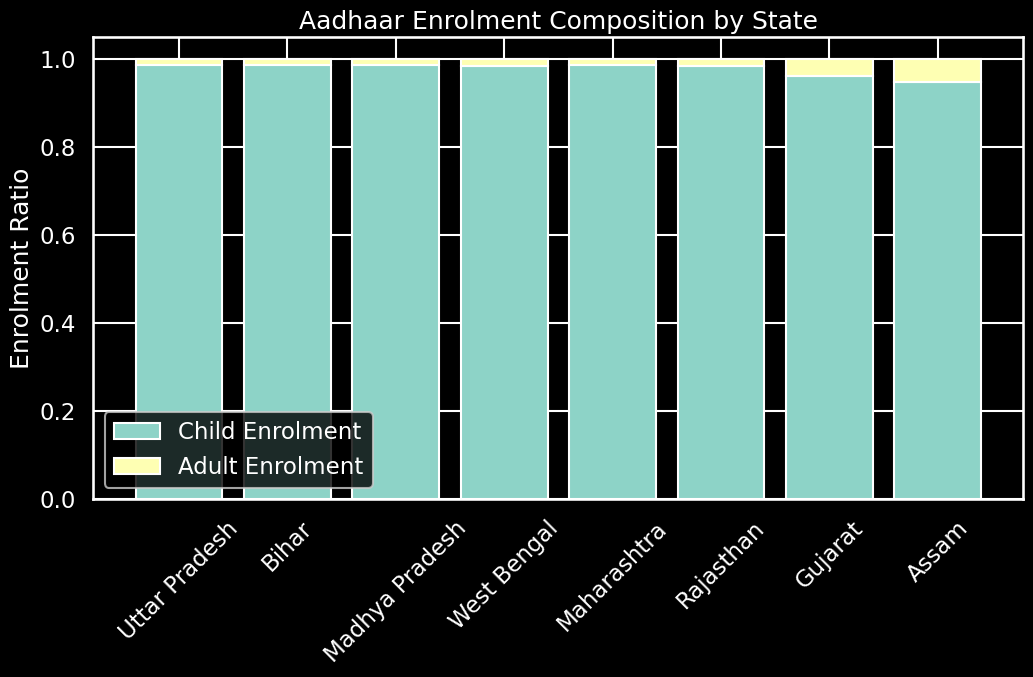

In [ ]:
# Select top 8 states to avoid clutter
top_states = (
    state_summary
    .sort_values('total_enrolment', ascending=False)
    .head(8)
)

plt.figure(figsize=(12,6))

plt.bar(
    top_states['state'],
    top_states['child_ratio'],
    label='Child Enrolment'
)

plt.bar(
    top_states['state'],
    top_states['adult_ratio'],
    bottom=top_states['child_ratio'],
    label='Adult Enrolment'
)

plt.ylabel("Enrolment Ratio")
plt.title("Aadhaar Enrolment Composition by State")
plt.xticks(rotation=45)
plt.legend()
plt.show()





In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.01, random_state=42)

df['anomaly'] = model.fit_predict(
    df[['age_0_5','age_5_17','age_18_greater']]
)

anomalies = df[df['anomaly'] == -1]

anomalies[['state','district','total_enrolment']].head()



,state,district,total_enrolment
417,Madhya Pradesh,Chhatarpur,78
418,Madhya Pradesh,Chhatarpur,52
427,Madhya Pradesh,Dewas,106
435,Madhya Pradesh,Guna,35
437,Madhya Pradesh,Guna,43


In [ ]:
state_total.to_csv("state_clusters.csv", index=False)
low_pincodes.to_csv("low_enrolment_pincodes.csv", index=False)
